In [1]:
!pip install wfdb
!pip install neurokit2 --upgrade neurokit2
import neurokit2 as nk
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks

In [3]:
#Loading the PTB-XL Dataset
df_path = "C:/ECG Project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv"
df = pd.read_csv(df_path, index_col="ecg_id")

#Displaying first few rows
print(df.head())


        patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15     

In [5]:
#Loading first ECG
ecg1_path = wfdb.rdrecord("C:/ECG Project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/00000/00001_hr")
signal1= ecg1_path.p_signal
print(signal1.shape)

(5000, 12)


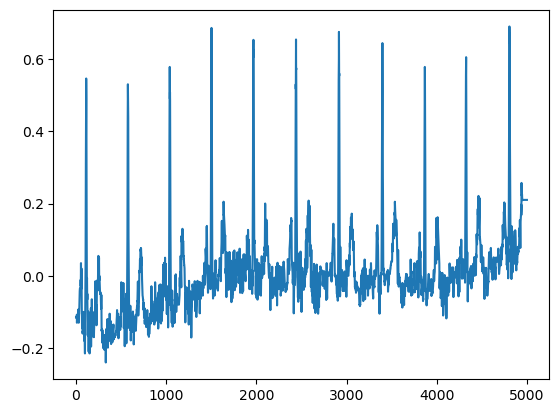

In [7]:
#Plotting lead 1 of first ECG
plt.plot(signal1[:,0])

In [9]:
base_path = "C:/ECG Project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

#Function that loads any ECG from the PTB-XL Dataset
def load_ecg(ecg_id, sampling_rate=500):
    ecg_record = df.loc[ecg_id,'filename_hr' if sampling_rate == 500 else 'filename_lr']
    full_path = os.path.join(base_path,ecg_record)
    try:
        signal, metadata = wfdb.rdsamp(full_path)
        return signal, metadata
    except FileNotFoundError:
        print(f"File not found: {full_path}")
        return None, None

#Testing the Function
ecg_signal, ecg_metadata = load_ecg(1)

if ecg_signal is not None:
    print("ECG Signal Shape:", ecg_signal.shape)
    print("Metadata:", ecg_metadata)
    

ECG Signal Shape: (5000, 12)
Metadata: {'fs': 500, 'sig_len': 5000, 'n_sig': 12, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'comments': []}


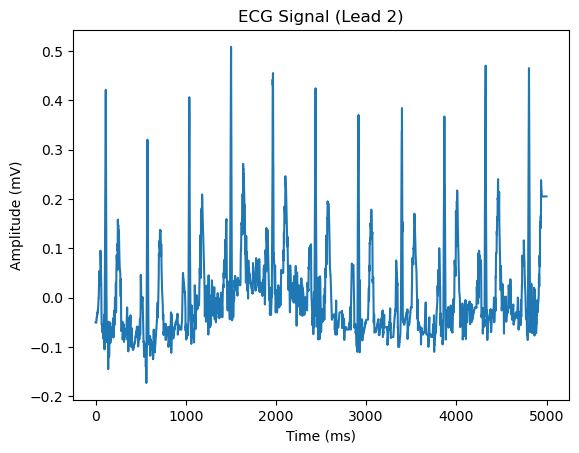

In [11]:
#Plotting the ECG
if ecg_signal is not None:
    plt.plot(ecg_signal[:,1])
    plt.title("ECG Signal (Lead 2)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (mV)")
    plt.show()

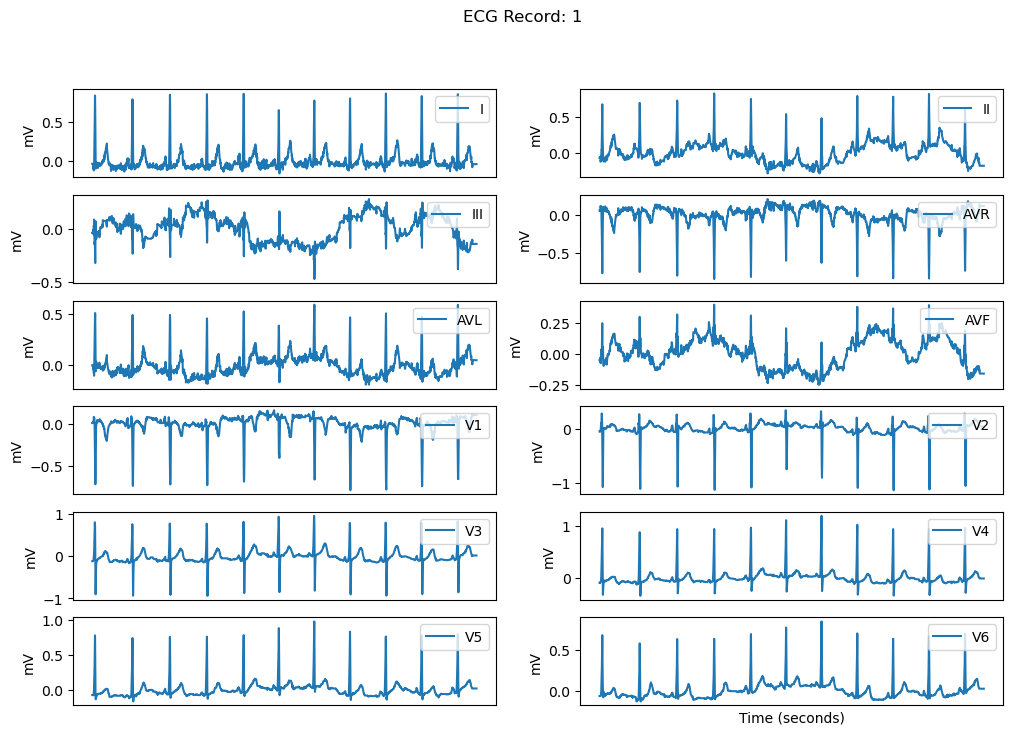

In [13]:
#Function that plots all ECG Leads
def plot_ecg(signal, metadata, ecg_id):
    leads = metadata['sig_name']
    sampling_frequency = metadata['fs']
    time = np.arange(signal.shape[0]) / sampling_frequency
    plt.figure(figsize=(12,8))
    for i in range(12):
        plt.subplot(6,2,i+1)
        plt.plot(time,signal[:,i], label = leads[i])
        plt.ylabel("mV")
        plt.legend(loc = "upper right")
        plt.xticks([])
    plt.xlabel("Time (seconds)")
    plt.suptitle(f"ECG Record: {ecg_id}")
    plt.show()

ecg_signal, ecg_metadata = load_ecg(3)
if ecg_signal is not None:
    plot_ecg(ecg_signal, ecg_metadata, 1)

    

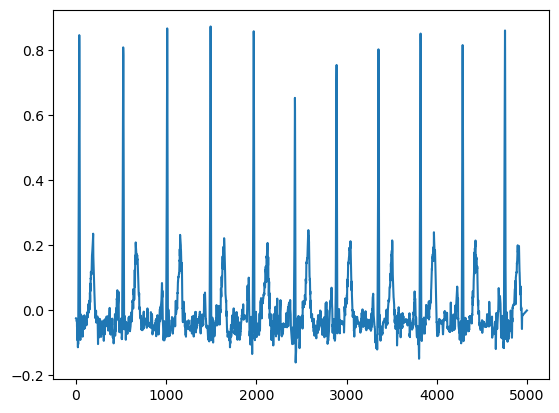

In [15]:
#Highpass Filter to fix baseline wander
def highpass_filter(signal, sampling_frequency, cutoff = 0.5):
    nyquist = 0.5 * sampling_frequency
    standard_cutoff = cutoff/nyquist
    b, a = butter(1, standard_cutoff, btype = "high", analog = False)
    return filtfilt(b,a, signal, axis = 0)

sampling_frequency = 500
highpass_ecg=highpass_filter(ecg_signal, sampling_frequency, cutoff = 0.5)

plt.plot(highpass_ecg[:,0])

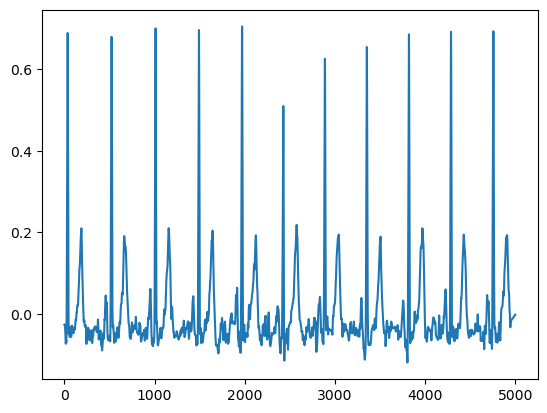

In [17]:
#Lowpass Filter to remove noise
def lowpass_filter(signal, sampling_frequency, cutoff=40):
    nyquist = 0.5 * sampling_frequency
    standard_cutoff = cutoff/nyquist
    b, a = butter(1, standard_cutoff, btype='low', analog=False)
    return filtfilt(b,a, signal, axis=0)

sampling_frequency = 500
filtered_ecg = lowpass_filter(highpass_ecg, sampling_frequency, cutoff=40)

plt.plot(filtered_ecg[:,0])

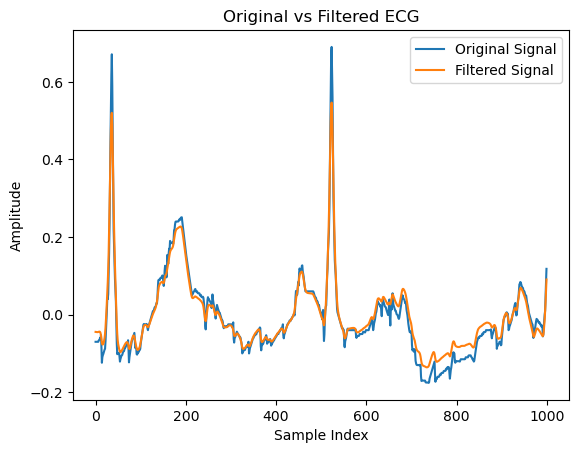

In [19]:
#Comparison between Orignal vs Filtered ECG
plt.plot(ecg_signal[:1000,1], label="Original Signal")
plt.plot(filtered_ecg[:1000,1], label="Filtered Signal")
plt.legend()
plt.title("Original vs Filtered ECG")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.savefig("Original VS Filtered", dpi=300, bbox_inches='tight')
plt.show()

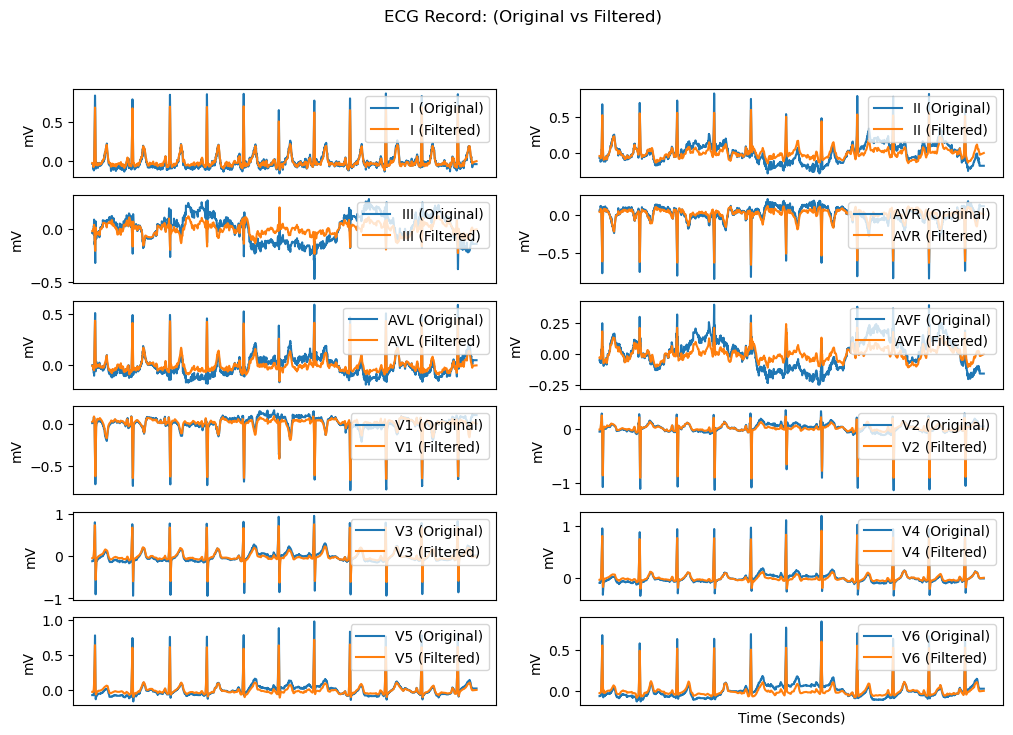

In [52]:
#Comparison of Original vs Filtered ECG for all 12 leads
def ecg_comparison(original_signal, filtered_signal, metadata, ecg_id):
    leads = metadata['sig_name']
    sampling_frequency = metadata['fs']
    time = np.arange(original_signal.shape[0]) / sampling_frequency
    plt.figure(figsize = (12,8))
    for i in range(12):
        plt.subplot(6,2,i+1)
        plt.plot(time, original_signal[:,i], label = f"{leads[i]} (Original)")
        plt.plot(time, filtered_signal[:,i], label = f"{leads[i]} (Filtered)")
        plt.ylabel("mV")
        plt.legend(loc="upper right")
        plt.xticks([])
    plt.xlabel("Time (Seconds)")
    plt.suptitle(f"ECG Record: (Original vs Filtered)")
    plt.savefig("Original VS Filtered 12 Lead 3.png", dpi=300, bbox_inches='tight')
    plt.show()

if ecg_signal is not None and filtered_ecg is not None:
    ecg_comparison(ecg_signal, filtered_ecg, ecg_metadata, 1)

In [22]:
def fold_ecg(signal, sampling_frequency):
    summed_signal = np.sum(np.abs(signal), axis=1)  # Sum absolute values across all leads
    peaks, _ = find_peaks(summed_signal, height=np.max(summed_signal) * 0.3, distance=0.4 * sampling_frequency)
    
    # Print detected peaks
    print(f"Detected R-peaks: {peaks}")

    if len(peaks) < 2:
        print("Not enough peaks detected for folding.")
        return None, None  # Ensure correct return values

    rr_intervals = np.diff(peaks) / sampling_frequency  # Compute RR intervals

    if len(rr_intervals) == 0:  #In case only one peak is found
        print("Only one R-peak detected; unable to fold.")
        return None, None

    avg_rr_interval = np.mean(rr_intervals) #Average RR interval
    segment_length = int(avg_rr_interval * sampling_frequency * 0.8)

    folded_segments = []

    for peak in peaks:
        start_index = peak - segment_length // 2
        end_index = peak + segment_length // 2
        
        if start_index >= 0 and end_index <= len(signal):  # Ensure valid indexing
            folded_segments.append(signal[start_index:end_index, :])
    
    folded_segments = np.array(folded_segments)

    # Debugging: Check if the number of folded segments matches detected R-peaks
    print(f"Number of folded segments: {len(folded_segments)}")


    return folded_segments, avg_rr_interval

# Apply function to filtered ECG
folded_ecg, avg_rr = fold_ecg(filtered_ecg, sampling_frequency=500)

if folded_ecg is not None:
    print("Folded ECG Shape:", folded_ecg.shape)


Detected R-peaks: [  36  523 1011 1492 1970 2427 2888 3353 3820 4286 4755]
Number of folded segments: 10
Folded ECG Shape: (10, 376, 12)


In [25]:
hr = 60/avg_rr
hr

63.572790845518114

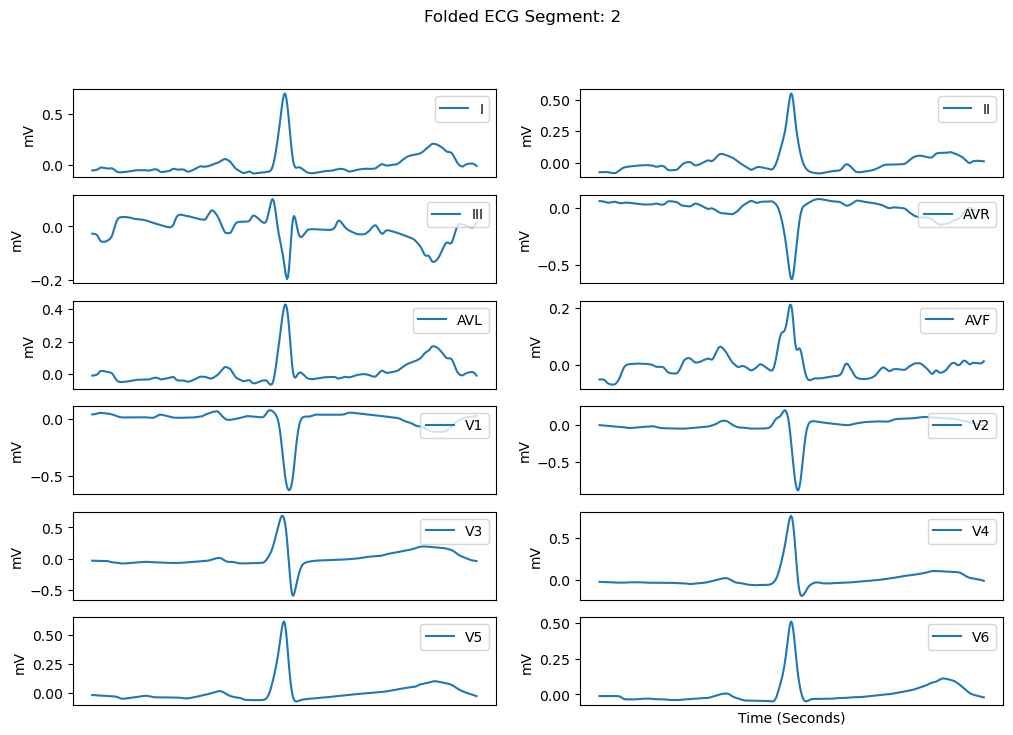

In [27]:
#Plotting Folded ECG
def plot_folded(folded_ecg, segment_id, metadata):
    leads = metadata['sig_name']
    segment = folded_ecg[segment_id]
    time = np.arange(segment.shape[0])/metadata['fs']
    plt.figure(figsize=(12,8))
    for i in range(12):
        plt.subplot(6,2,i+1)
        plt.plot(time, segment[:,i], label = f"{leads[i]}")
        plt.ylabel("mV")
        plt.legend(loc="upper right")
        plt.xticks([])
    plt.xlabel("Time (Seconds)")
    plt.suptitle(f"Folded ECG Segment: {segment_id+1}")
    plt.show()

plot_folded(folded_ecg,1, ecg_metadata)


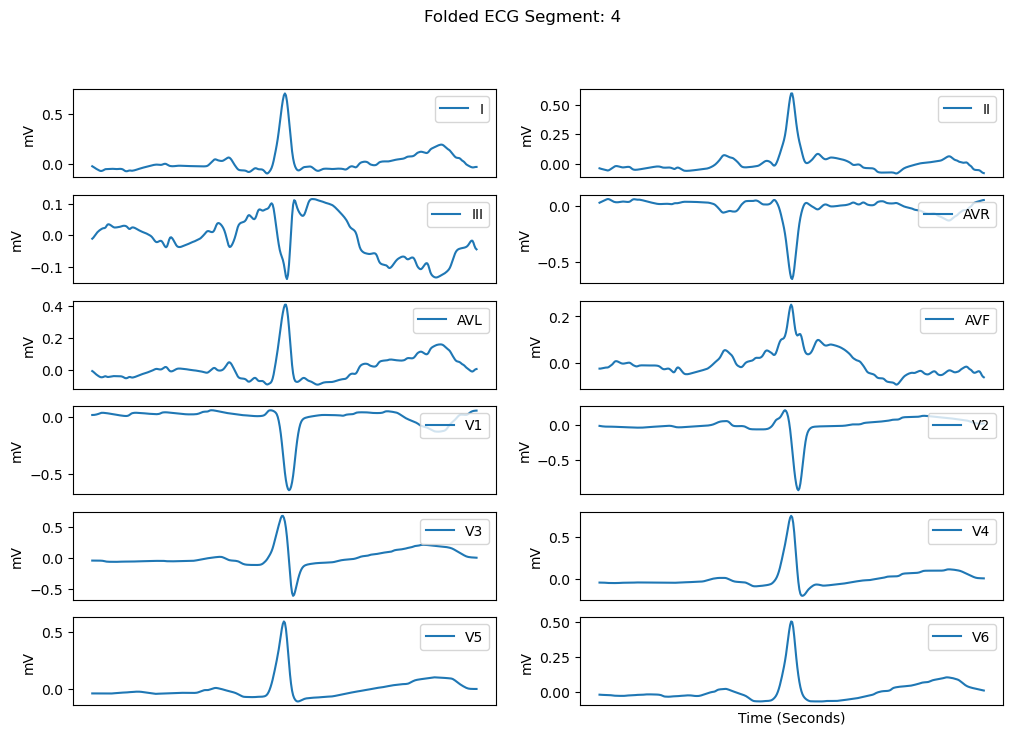

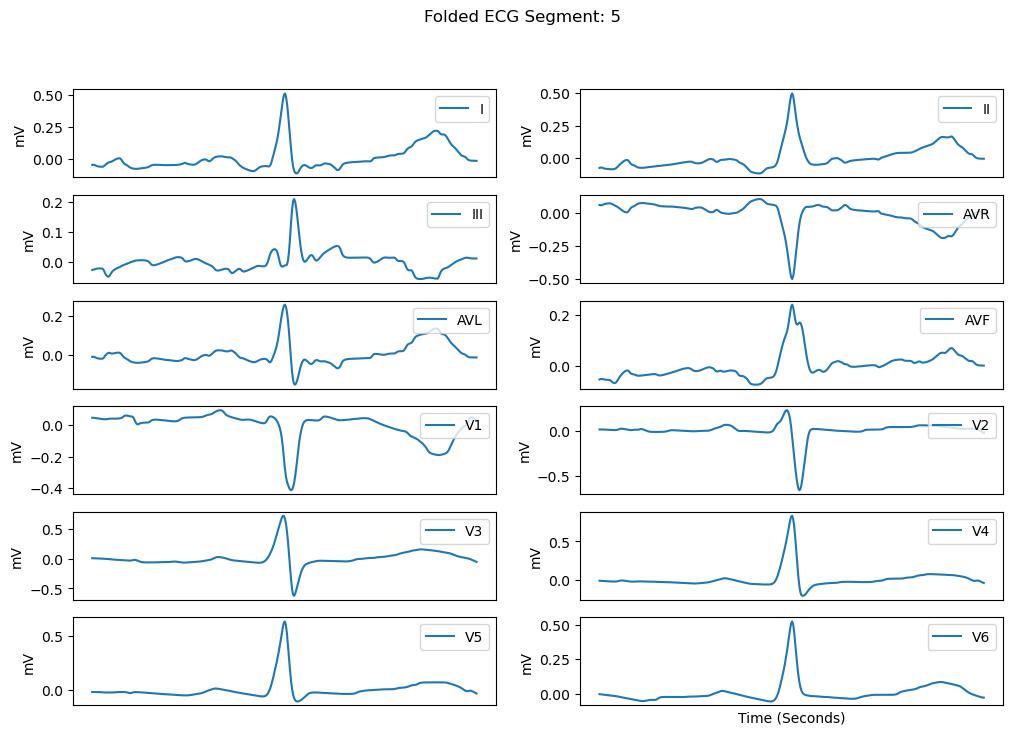

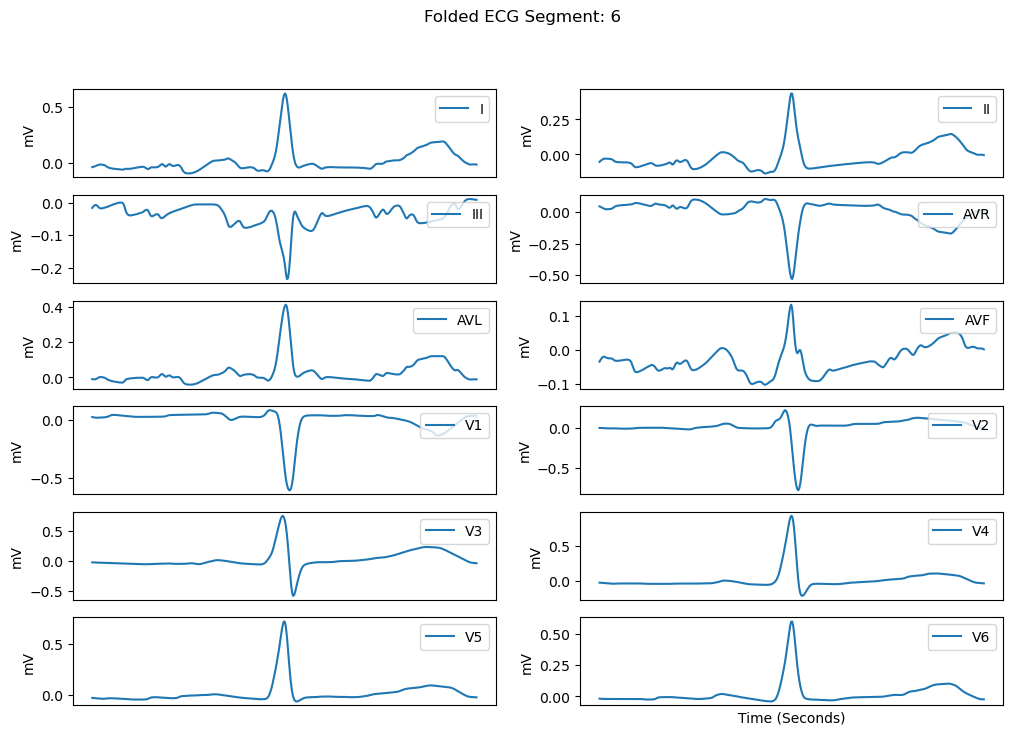

In [29]:
#Plotting Multiple Segments to check R Peaks don't overlap between Folds
def plot_multiple_segments(folded_ecg, segment_ids, metadata):
    for segment_id in segment_ids:
        plot_folded(folded_ecg, segment_id, metadata)
plot_multiple_segments(folded_ecg, [3,4,5], ecg_metadata)

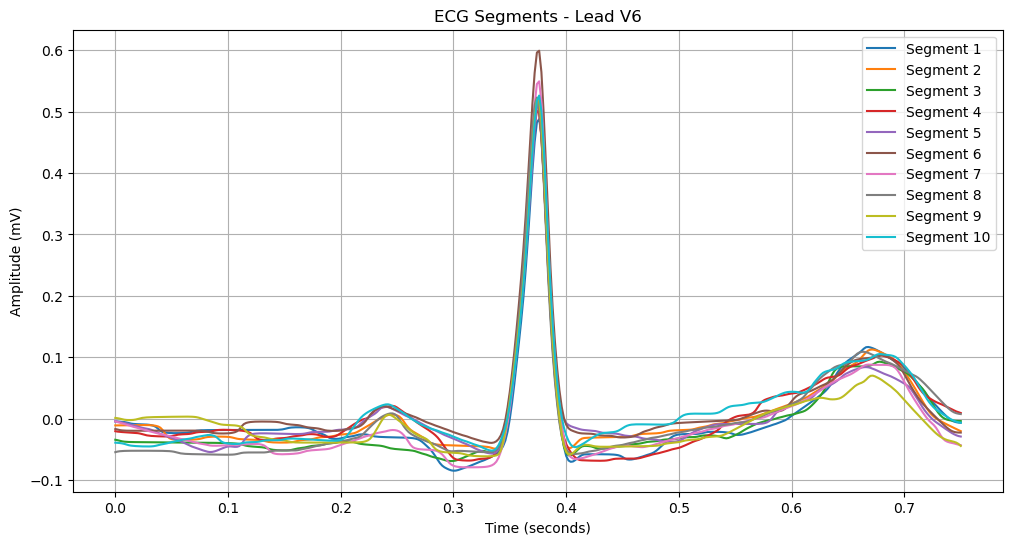

In [64]:
#Visualing beat alignment in Lead V6
def plot_multiple_segments_lead12(folded_ecg, segment_ids, metadata):
    sampling_frequency = metadata['fs']
    time = np.arange(folded_ecg.shape[1]) / sampling_frequency  # Time axis

    plt.figure(figsize=(12, 6))
    
    # Plot each segment for Lead 12 (index 11)
    for segment_id in segment_ids:
        plt.plot(time, folded_ecg[segment_id, :, 11], label=f'Segment {segment_id+1}')
    
    plt.title('ECG Segments - Lead V6')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (mV)')
    plt.legend()
    plt.savefig('folded 3')
    plt.grid(True)
    plt.show()
    

plot_multiple_segments_lead12(folded_ecg, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ecg_metadata)



In [66]:
#Generating an Average ECG of Folded Segments
def average_ecg(folded_ecg):
    average_signal = np.mean(folded_ecg, axis = 0)
    return average_signal


average_signal = average_ecg(folded_ecg)
print("Average ECG Shape:", average_signal.shape)

Average ECG Shape: (376, 12)


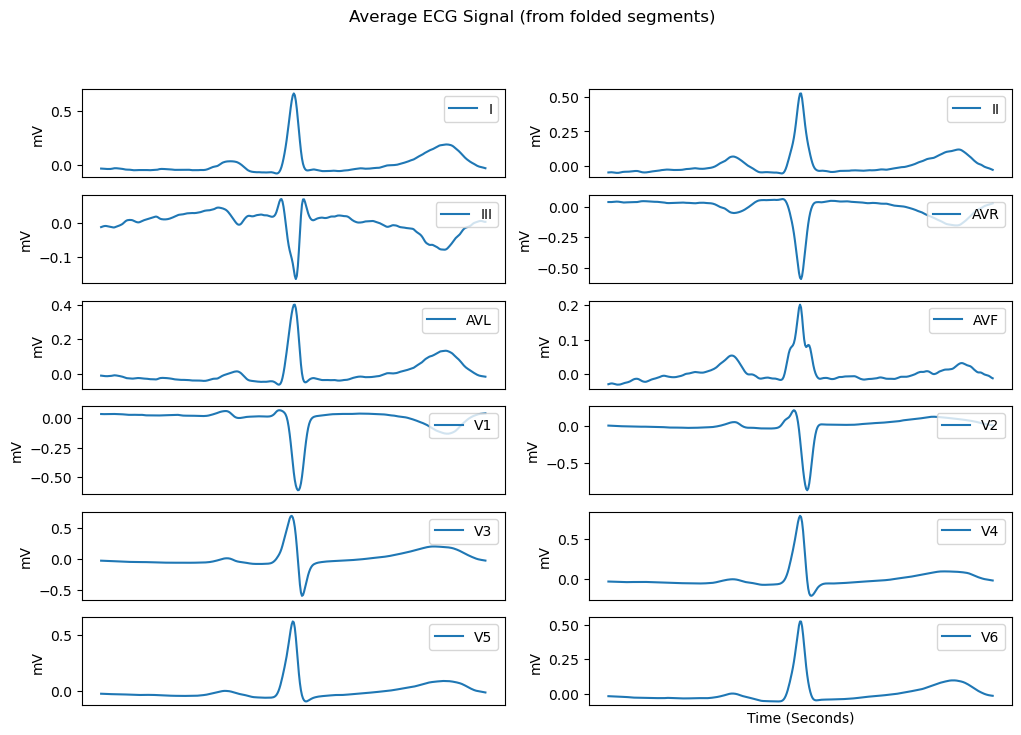

In [68]:
#Plotting the Average ECG of Folded Segments
def plot_average_ecg(average_signal, metadata):
    leads = metadata['sig_name']
    sampling_frequency = metadata['fs']
    time = np.arange(average_signal.shape[0]) / sampling_frequency
    plt.figure(figsize = (12,8))
    for i in range(12):
        plt.subplot(6,2,i+1)
        plt.plot(time, average_signal[:,i], label=f"{leads[i]}")
        plt.ylabel("mV")
        plt.legend(loc = "upper right")
        plt.xticks([])
    plt.xlabel("Time (Seconds)")
    plt.suptitle("Average ECG Signal (from folded segments)")
    plt.savefig("Average Folded Signal 3.png", dpi=300, bbox_inches='tight')
    plt.show()
    
plot_average_ecg(average_signal, ecg_metadata)
    

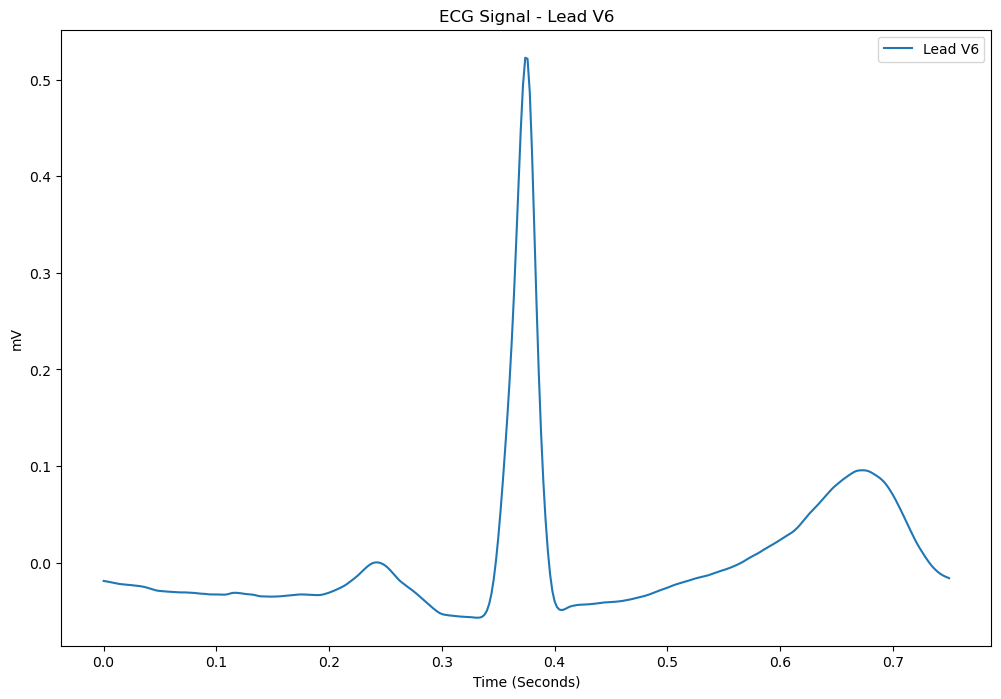

In [37]:
# Plotting only Lead V6
lead_V6 = average_signal[:,11]
def plot_lead_V6(lead_V6, metadata):
    sampling_frequency = metadata['fs']
    time = np.arange(lead_V6.shape[0]) / sampling_frequency
    plt.figure(figsize=(12, 8))
    plt.plot(time, lead_V6, label="Lead V6")
    plt.ylabel("mV")
    plt.legend(loc="upper right")
    plt.xlabel("Time (Seconds)")
    plt.title("ECG Signal - Lead V6")
    plt.savefig("Average Folded Signal 4020.png", dpi=300, bbox_inches='tight')
    plt.show()


plot_lead_V6(lead_V6, ecg_metadata)


QRS Duration (ms), P onset, P peak, P amplitude, Q wave, Q amplitude, R wave, R amplitude, S wave, S amplitude, T onset, T peak, T amplitude, T end for Lead V6: [(74.0, 0.206, 0.242, 0.0002572103246189832, 0.332, -0.057045186052958566, 0.374, 0.5226763766731317, 0.406, -0.04914129385765955, 0.56, 0.674, 0.09559265006526738, None)]


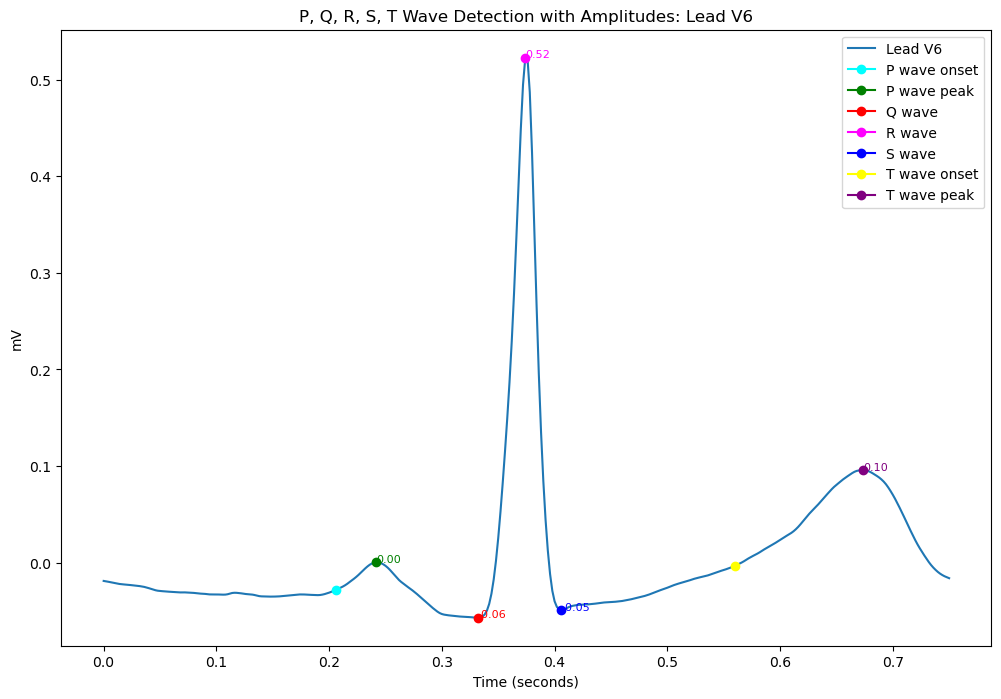

In [39]:
# PQRST Feature Extraction 
def detect_pqrst(lead_signal, sampling_frequency=500):
    pqrs_intervals = []

    lead_signal_filtered = lead_signal

    # Detect R peaks
    amplitude_difference = np.max(lead_signal_filtered) - np.min(lead_signal_filtered)
    height_r = amplitude_difference * 0.5  # R peak threshold
    r_peaks, _ = find_peaks(lead_signal_filtered, height=height_r)

    for r in r_peaks:
        t_wave_end = None
        # Detect Q wave (local minimum before R)
        q_candidates, _ = find_peaks(-lead_signal_filtered[:r])
        if len(q_candidates) == 0:
            continue
        q_wave = q_candidates[-1]
        q_amplitude = lead_signal_filtered[q_wave]

        # Detect S wave (local minimum after R)
        s_candidates, _ = find_peaks(-lead_signal_filtered[r:])
        if len(s_candidates) == 0:
            continue
        s_wave = s_candidates[0] + r
        s_amplitude = lead_signal_filtered[s_wave]

        # Detect P wave peak (largest maximum before Q)
        window_start = max(0, q_wave - int(0.6 * sampling_frequency))
        window_end = q_wave
        p_candidates, _ = find_peaks(lead_signal_filtered[window_start:window_end])

        if len(p_candidates) == 0:
            continue

        p_peak = max(p_candidates, key=lambda p: lead_signal_filtered[p + window_start]) + window_start
        p_amplitude = lead_signal_filtered[p_peak]

        # Find P wave onset
        p_wave_start = p_peak
        baseline = np.mean(lead_signal_filtered[window_start:p_peak])
        for i in range(p_peak - 1, window_start, -1):
            if lead_signal_filtered[i] < baseline and lead_signal_filtered[i + 1] >= baseline:
                p_wave_start = i
                break

        # Detect T wave onset
        t_wave_onset = None
        t_window_start = s_wave + int(0.05 * sampling_frequency)
        t_window_end = s_wave + int(1.0 * sampling_frequency)
        t_window_start = min(t_window_start, len(lead_signal_filtered) - 1)
        t_window_end = min(t_window_end, len(lead_signal_filtered) - 1)

        slope_threshold = 0.001
        for i in range(t_window_start + 1, t_window_end):
            if lead_signal_filtered[i] > lead_signal_filtered[i - 1]:
                if lead_signal_filtered[i] - lead_signal_filtered[i - 1] > slope_threshold:
                    t_wave_onset = i
                    break

        # Detect T wave peak
        t_wave_peak = None
        t_peak_candidates, _ = find_peaks(lead_signal_filtered[t_window_start:t_window_end])

        if len(t_peak_candidates) > 0:
            t_wave_peak = max(t_peak_candidates, key=lambda p: lead_signal_filtered[p + t_window_start]) + t_window_start
            t_amplitude = lead_signal_filtered[t_wave_peak]
        else:
            t_wave_peak, t_amplitude = None, None

        # T wave end detection
        if t_wave_peak is not None:
            t_end_search_start = t_wave_peak + int(0.05 * sampling_frequency)
            t_end_search_end = t_wave_peak + int(1.5 * sampling_frequency)
            derivative_signal = np.diff(lead_signal_filtered[t_end_search_start:t_end_search_end])
            for i in range(1, len(derivative_signal)):
                if abs(derivative_signal[i]) < 0.0005:
                    t_wave_end = t_end_search_start + i
                    break
        else:
            t_wave_end = None

        # R peak amplitude
        r_amplitude = lead_signal_filtered[r]

        # Compute QRS duration in milliseconds
        qrs_duration = ((s_wave - q_wave) / sampling_frequency) * 1000

        pqrs_intervals.append((p_wave_start, p_peak, p_amplitude,
                               q_wave, q_amplitude, 
                               r, r_amplitude, 
                               s_wave, s_amplitude, 
                               t_wave_onset, t_wave_peak, t_amplitude, t_wave_end, 
                               qrs_duration))

    return pqrs_intervals
lead_V6_signal = np.array(lead_V6)
# Call the Function
pqrs_data = detect_pqrst(lead_V6_signal, sampling_frequency=500)

# Convert to seconds and include amplitudes
pqrs_seconds = []
for pqrs in pqrs_data:
    (p_wave_start, p_peak, p_amplitude, 
     q_wave, q_amplitude, 
     r_peak, r_amplitude, 
     s_wave, s_amplitude, 
     t_wave_onset, t_wave_peak, t_amplitude, t_wave_end, 
     qrs_duration_ms) = pqrs

    pqrs_seconds.append((
        qrs_duration_ms,
        p_wave_start / 500 if p_wave_start is not None else None,
        p_peak / 500 if p_peak is not None else None,
        p_amplitude,
        q_wave / 500, q_amplitude,
        r_peak / 500, r_amplitude,
        s_wave / 500, s_amplitude,
        t_wave_onset / 500 if t_wave_onset is not None else None,
        t_wave_peak / 500 if t_wave_peak is not None else None,
        t_amplitude,
        t_wave_end / 500 if t_wave_end is not None else None
    ))

print(f"QRS Duration (ms), P onset, P peak, P amplitude, Q wave, Q amplitude, R wave, R amplitude, "
      f"S wave, S amplitude, T onset, T peak, T amplitude, T end for Lead V6: {pqrs_seconds}")


#Plotting the ECG
def plot_qrst(lead_signal, pqrs_data, sampling_frequency=500):
    time = np.arange(len(lead_signal)) / sampling_frequency
    plt.figure(figsize=(12, 8))
    plt.plot(time, lead_signal, label="Lead V6")

    for pqrs in pqrs_data:
        (p_wave_start, p_peak, p_amplitude,
         q_wave, q_amplitude,
         r_peak, r_amplitude,
         s_wave, s_amplitude,
         t_wave_onset, t_wave_peak, t_amplitude, t_wave_end,
         _) = pqrs  # Ignore QRS duration for plotting

        # Plot each detected wave and its amplitude as text
        if p_wave_start is not None:
            plt.plot(time[p_wave_start], lead_signal[p_wave_start], 'cyan', marker='o', label="P wave onset" if 'P wave onset' not in plt.gca().get_legend_handles_labels()[1] else "")
        if p_peak is not None:
            plt.plot(time[p_peak], lead_signal[p_peak], 'green', marker='o', label="P wave peak" if 'P wave peak' not in plt.gca().get_legend_handles_labels()[1] else "")
            plt.text(time[p_peak], lead_signal[p_peak], f"{p_amplitude:.2f}", fontsize=8, color='green')

        if q_wave is not None:
            plt.plot(time[q_wave], lead_signal[q_wave], 'red', marker='o', label="Q wave" if 'Q wave' not in plt.gca().get_legend_handles_labels()[1] else "")
            plt.text(time[q_wave], lead_signal[q_wave], f"{q_amplitude:.2f}", fontsize=8, color='red')

        if r_peak is not None:
            plt.plot(time[r_peak], lead_signal[r_peak], 'magenta', marker='o', label="R wave" if 'R wave' not in plt.gca().get_legend_handles_labels()[1] else "")
            plt.text(time[r_peak], lead_signal[r_peak], f"{r_amplitude:.2f}", fontsize=8, color='magenta')

        if s_wave is not None:
            plt.plot(time[s_wave], lead_signal[s_wave], 'blue', marker='o', label="S wave" if 'S wave' not in plt.gca().get_legend_handles_labels()[1] else "")
            plt.text(time[s_wave], lead_signal[s_wave], f"{s_amplitude:.2f}", fontsize=8, color='blue')

        if t_wave_onset is not None:
            plt.plot(time[t_wave_onset], lead_signal[t_wave_onset], 'yellow', marker='o', label="T wave onset" if 'T wave onset' not in plt.gca().get_legend_handles_labels()[1] else "")

        if t_wave_peak is not None:
            plt.plot(time[t_wave_peak], lead_signal[t_wave_peak], 'purple', marker='o', label="T wave peak" if 'T wave peak' not in plt.gca().get_legend_handles_labels()[1] else "")
            plt.text(time[t_wave_peak], lead_signal[t_wave_peak], f"{t_amplitude:.2f}", fontsize=8, color='purple')

        if t_wave_end is not None:
            plt.plot(time[t_wave_end], lead_signal[t_wave_end], 'orange', marker='o', label="T wave end" if 'T wave end' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel("Time (seconds)")
    plt.ylabel("mV")
    plt.legend(loc="upper right")
    plt.title("P, Q, R, S, T Wave Detection with Amplitudes: Lead V6")
    plt.savefig("Normal 2.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_qrst(lead_V6_signal, pqrs_data, sampling_frequency=500)


In [43]:
# Loading all ECG samples and metadata
sample_ecg = []
sample_metadata = []

for ecg_id in df.index:
    signal, metadata = load_ecg(ecg_id, sampling_rate=500)
    if signal is not None:
        sample_ecg.append(signal.astype(np.float32))  # ← Converting into float32
        sample_metadata.append(metadata)

sample_ecg = np.array(sample_ecg)  # with less memory
print("Loaded ECG Dataset Shape:", sample_ecg.shape)
print(len(sample_ecg))


Loaded ECG Dataset Shape: (21799, 5000, 12)
21799


In [ ]:
#Applying the pipeline on the whole sample
pqrst_data = []
preprocessed_ecgs = []

for ecg_id, ecg in zip(df.index, sample_ecg):
    # Apply high-pass filter
    hp_filtered_signal = highpass_filter(ecg, sampling_frequency=500, cutoff=0.5)
    
    # Apply low-pass filter
    lp_filtered_signal = lowpass_filter(hp_filtered_signal, sampling_frequency=500, cutoff=40)
    
    # Apply folding to the filtered signal
    folded_signal, avg_rr = fold_ecg(lp_filtered_signal, sampling_frequency=500)
    
    if folded_signal is not None and folded_signal.size > 0:
        average_ecg_signal = average_ecg(folded_signal)
        preprocessed_ecgs.append(average_ecg_signal)
        
        lead_v6 = average_ecg_signal[:, -1]  # Lead V6 is the last column
        pqrst_intervals = detect_pqrst(lead_v6, sampling_frequency=500)
        heart_rate = round(60/avg_rr, 2) if avg_rr is not None else None
        # Store using actual ECG ID
        pqrst_data.append((ecg_id, pqrst_intervals, avg_rr, heart_rate))
        
        print(f"ECG ID {ecg_id}: Detected PQRST intervals: {pqrst_intervals}, Heart Rate: {heart_rate}")

# After the loop, print the total number of ECGs processed
print(f"Total ECGs Processed: {len(preprocessed_ecgs)}")


Detected R-peaks: [ 113  576 1040 1502 1967 2439 2915 3397 3868 4324 4811]
Number of folded segments: 10
ECG ID 1: Detected PQRST intervals: [(98, 130, 0.019654474761953724, 171, -0.06079931979811233, 188, 0.38547739879456977, 242, -0.04881894316148126, 275, 328, 0.14729843485201632, None, 142.0)], Heart Rate: 63.86
Detected R-peaks: [ 504 1156 1840 2513 3139 3737 4318]
Number of folded segments: 7
ECG ID 2: Detected PQRST intervals: [(161, 182, -0.0028234662945527855, 238, -0.13066729053521295, 254, 1.1761427142445469, 268, -0.0835750362587208, 294, 392, 0.3227913198111477, 445, 60.0)], Heart Rate: 47.19
Detected R-peaks: [  36  523 1011 1492 1970 2427 2888 3353 3820 4286 4755]
Number of folded segments: 10
ECG ID 3: Detected PQRST intervals: [(103, 121, 0.00025720985289893886, 166, -0.05704518670230611, 187, 0.5226763781484028, 203, -0.04914129343468031, 280, 337, 0.0955926501399248, None, 74.0)], Heart Rate: 63.57
Detected R-peaks: [ 152  542  958 1394 1823 2232 2613 3006 3402 3815 

In [50]:
#Creating Dataset with PQRST values
processed_pqrst_data = []

for ecg_id, intervals, avg_rr, heart_rate in pqrst_data: 
    if isinstance(intervals, list) and len(intervals) == 1 and isinstance(intervals[0], tuple):
        intervals = intervals[0]  

    # Ensure intervals is a tuple with the correct structure
    if isinstance(intervals, tuple) and len(intervals) >= 14:
        (p_wave_start, p_peak, p_amplitude,
         q_wave, q_amplitude,
         r_peak, r_amplitude,
         s_wave, s_amplitude,
         t_wave_onset, t_wave_peak, t_amplitude, t_wave_end,
         qrs_duration_ms) = intervals[:14]  # Extract first 14 values

        # Calculate PR and ST intervals in seconds
        pr_interval = (r_peak - p_wave_start) / 500 if p_wave_start is not None and r_peak is not None else None
        st_interval = (t_wave_peak - s_wave) / 500 if s_wave is not None and t_wave_peak is not None else None

        # Append values with ECG ID and heart rate
        processed_pqrst_data.append([
            ecg_id,
            1000 * p_wave_start / 500 if p_wave_start is not None else None,
            1000 * p_peak / 500 if p_peak is not None else None,
            1000 * q_wave / 500 if q_wave is not None else None,
            1000 * r_peak / 500 if r_peak is not None else None,
            1000 * s_wave / 500 if s_wave is not None else None,
            1000 * t_wave_onset / 500 if t_wave_onset is not None else None,
            1000 * t_wave_peak / 500 if t_wave_peak is not None else None,
            1000 * t_wave_end / 500 if t_wave_end is not None else None,
            qrs_duration_ms,
            1000 * pr_interval if pr_interval is not None else None,
            1000 * st_interval if st_interval is not None else None,
            p_amplitude,
            q_amplitude,
            r_amplitude,
            s_amplitude,
            t_amplitude,
            avg_rr*1000,
            heart_rate  # Include heart rate in the data
        ])

    else:
        print(f"Skipping ECG {ecg_id} due to incorrect PQRST shape: {intervals}")


# Create DataFrame
if processed_pqrst_data:
    pqrst_df = pd.DataFrame(processed_pqrst_data, columns=[
        'ecg_id', 'P onset', 'P Peak', 'Q', 'R', 'S', 'T onset', 'T peak', 'T end',
        'QRS Duration (ms)', 'PR Interval (ms)', 'ST Interval (ms)',
        'P Amplitude', 'Q Amplitude', 'R Amplitude', 'S Amplitude', 'T Amplitude', 'Average RR (ms)',
        'Heart Rate (bpm)'  # Add heart rate as a column
    ])

    print(pqrst_df)
    pqrst_df.to_csv('pqrst_intervals.csv', index=False)  # Save with heart rate
    print("PQRST intervals with heart rate saved to pqrst_intervals_with_heart_rate.csv")
else:
    print("No valid PQRST intervals detected.")


Skipping ECG 144 due to incorrect PQRST shape: []
Skipping ECG 162 due to incorrect PQRST shape: []
Skipping ECG 177 due to incorrect PQRST shape: []
Skipping ECG 180 due to incorrect PQRST shape: [(15, 15, -0.06430692837357585, 68, -0.09759676247297223, 131, 1.5085066066015773, 141, 1.4572623565609664, 180, 186, -0.5738139627843495, 222, 146.0), (108, 131, 1.5085066066015773, 141, 1.4572623565609664, 145, 1.4673234379373523, 179, -0.5881898630183364, 225, None, None, None, 76.0)]
Skipping ECG 181 due to incorrect PQRST shape: [(58, 69, -0.006049208225678418, 101, -0.03810909162041217, 111, 0.09944778358602692, 123, -0.039235408817968026, None, 189, 0.020303214756914552, 222, 44.0), (104, 111, 0.09944778358602692, 123, -0.039235408817968026, 133, 0.0766899067218831, 158, 0.015720534699901097, None, 189, 0.020303214756914552, 222, 70.0)]
Skipping ECG 182 due to incorrect PQRST shape: []
Skipping ECG 184 due to incorrect PQRST shape: []
Skipping ECG 189 due to incorrect PQRST shape: []
S